In [60]:
# Imports
import torch
import torch.nn as nn  # All neural network modules 
import torch.nn.init as init    # For weight initializations
import torch.optim as optim  # For all optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a clear way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from tqdm import tqdm # For progress bars 
import matplotlib.pyplot as plt # For graphing  
import numpy as np  # For graphing  
import pandas as pd     # For data frames
import seaborn as sns   # For graphing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [61]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 12000
num_epoches = 5

In [62]:
# Get MNIST data
train_ds = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

test_ds = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

# Print the number of images in the training set
print("Number of training images:", len(train_ds))

# Print the number of images in the test set
print("Number of test images:", len(test_ds))


Number of training images: 60000
Number of test images: 10000


In [63]:
class OverallNet(nn.Module):
  def __init__(self, num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers):
    super().__init__()
    # Input: 28 by 28 pixel image = 784 artifical neurons
    # Output: Digit from zero to nine
    
    if num_dendrite_neuron_layers == 1:
      self.layer1 = nn.Linear(784, num_dendritic_inputs)
      self.layer2 = nn.Linear(num_dendritic_inputs, num_neurons)
      self.layer3 = nn.Linear(num_neurons, 10)

      # Apply He weight initialization
      init.kaiming_uniform_(self.layer1.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer2.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer3.weight, mode="fan_in", nonlinearity="relu")

    elif num_dendrite_neuron_layers == 2:
      self.layer1 = nn.Linear(784, num_dendritic_inputs)
      self.layer2 = nn.Linear(num_dendritic_inputs, num_neurons)
      self.layer3 = nn.Linear(num_neurons, num_dendritic_inputs)
      self.layer4 = nn.Linear(num_dendritic_inputs, num_neurons)
      self.layer5 = nn.Linear(num_neurons, 10)

    # Apply He weight initialization
      init.kaiming_uniform_(self.layer1.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer2.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer3.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer4.weight, mode="fan_in", nonlinearity="relu")
      init.kaiming_uniform_(self.layer5.weight, mode="fan_in", nonlinearity="relu")

    self.R = nn.ReLU()

  def forward(self, x, num_neurons, chunk_size, num_dendrite_neuron_layers):
    x = x.view(-1,28**2)
    x = self.R(self.layer1(x))

    # Debug only: 
    # print(x.size())
    # print(self.layer2.bias.size())

    somas_1 = []
  
    # Iterate through all output neurons to get their individual feedforward result
    # Layer 2 to 3 dendrites to somas
    for i in range(num_neurons):
      chunk_neuron_input = x[:, (chunk_size * i):(chunk_size * i + chunk_size)]   # Divide chunk of converging inputs by 8
      layer2_weights = nn.Parameter(self.layer2.weight[i, (chunk_size * i):(chunk_size * i + chunk_size)].unsqueeze(0))   # Divide chunk of converging weights by 16
      layer2_bias = nn.Parameter(self.layer2.bias[i]) # Set bias for the nueron of interest
  
      # Debug only: 
      # print(chunk_neuron_input.size())
      # print(layer2_weights.size())
      # print(layer2_bias.size())
      
      neuron_forward = self.R(torch.mm(chunk_neuron_input, layer2_weights.t()) + layer2_bias)
      
      somas_1.append(neuron_forward)
      
      # Debug only: 
      # print(somas)

    x = torch.cat(somas_1, dim=1) # concatenate the resulting matrices of layer 2
    x = self.R(self.layer3(x))

    # Debug only: 
    # print(x.size())
    # print(self.layer4.weight.size())
    # print(self.layer5.bias.size())
    # print(self.layer5.bias)

    if num_dendrite_neuron_layers == 2:
      somas_2 = []

      # Layer 4 to 5 dendrites to somas
      for i in range(num_neurons):
          # print(i)
          chunk_neuron_input = x[:, (chunk_size * i):(chunk_size * i + chunk_size)]   # Divide chunk of converging inputs by 8
          layer4_weights = nn.Parameter(self.layer4.weight[i, (chunk_size * i):(chunk_size * i + chunk_size)].unsqueeze(0))   # Divide chunk of converging weights by 16
          layer4_bias = nn.Parameter(self.layer4.bias[i]) # Set bias for the nueron of interest
      
          # Debug only: 
          # print(layer5_bias)
          # print(chunk_neuron_input.size())
          # print(layer4_weights.size())
          # print(layer5_bias.size())
          
          neuron_forward = self.R(torch.mm(chunk_neuron_input, layer4_weights.t()) + layer4_bias)
          
          somas_2.append(neuron_forward)
          
          # Debug only: 
          # print(somas)

      x = torch.cat(somas_2, dim=1) # concatenate the resulting matrices of layer 4

      x = self.R(self.layer5(x))
    
    return x

In [64]:
# Check parameter matrix sizes
def print_parameter_info(model):
    for name, param in model.named_parameters():
        print(name)
        print(type(param), param.size())

In [65]:
def freeze_network_layers(model):
  # Freeze weights and biases
  for name, param in model.named_parameters():
    # Freeze layer 1's weights and biases if set to False
    if param.requires_grad and 'layer1' in name:
        param.requires_grad = True
    # Freeze layer 2's weights and biases
    elif param.requires_grad and 'layer2' in name: 
        param.requires_grad = False               
    # # Freeze layer 3's weights and biases if set to False
    # elif param.requires_grad and 'layer3' in name:
    #     param.requires_grad = True
    # # Freeze layer 4's weights and biases 
    # elif param.requires_grad and 'layer4' in name:
    #     # Freeze layer 4's weights and biases if set to False
    #     param.requires_grad = True

In [66]:
# Train Network
def train_network(device, num_epoches, train_loader, model, criterion, optimizer, num_neurons, chunk_size, num_dendrite_neuron_layers):
    for epoch in range(num_epoches):
        losses = []

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data, num_neurons, chunk_size, num_dendrite_neuron_layers)
            loss = criterion(scores, targets)

            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


In [67]:
def check_accuracy(loader, model, num_neurons, chunk_size, num_dendrite_neuron_layers):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x, num_neurons, chunk_size, num_dendrite_neuron_layers)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        accuracy = float(num_correct)/float(num_samples)
        print(f"Got {num_correct} / {num_samples} with accuracy {accuracy*100:.2f}%")

    # Set the model mode to train
    model.train()
    return accuracy

In [68]:
def run_trials(num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers, num_trainings):
  acc_dict = {}
  acc_dict[0] = 0

  chunk_size = num_dendritic_inputs // num_neurons
  model = OverallNet(num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers)
  freeze_network_layers(model)
  print_parameter_info(model) 
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  for training in range(num_trainings):
    train_network(device, num_epoches, train_loader, model, criterion, optimizer, num_neurons, chunk_size, num_dendrite_neuron_layers)
    
    acc_dict[training + 1] = check_accuracy(test_loader, model, num_neurons, chunk_size, num_dendrite_neuron_layers)
    print(f"Row: {training + 1} | {num_dendritic_inputs} | {num_neurons} | {list(acc_dict.values())}")

  # Plot graph of accuracies after the trial
  ypoints = np.array(list(acc_dict.values()))
  plt.xticks(np.arange(0, len(ypoints), 1.0))
  plt.xlabel("Number of trainings")
  plt.ylabel("Accuracy")
  plt.title(f"{num_dendrite_neuron_layers} layers of {num_dendritic_inputs} dendrites and {num_neurons} neurons")
  plt.plot(ypoints)
  plt.show()

  return list(acc_dict.values())

--- NEW MODEL 0 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 5846 / 10000 with accuracy 58.46%
Row: 1 | 392 | 14 | [0, 0.5846]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 6914 / 10000 with accuracy 69.14%
Row: 2 | 392 | 14 | [0, 0.5846, 0.6914]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7087 / 10000 with accuracy 70.87%
Row: 3 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 7174 / 10000 with accuracy 71.74%
Row: 4 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7239 / 10000 with accuracy 72.39%
Row: 5 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 7277 / 10000 with accuracy 72.77%
Row: 6 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7314 / 10000 with accuracy 73.14%
Row: 7 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7337 / 10000 with accuracy 73.37%
Row: 8 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7348 / 10000 with accuracy 73.48%
Row: 9 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7377 / 10000 with accuracy 73.77%
Row: 10 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348, 0.7377]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7392 / 10000 with accuracy 73.92%
Row: 11 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348, 0.7377, 0.7392]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7410 / 10000 with accuracy 74.10%
Row: 12 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348, 0.7377, 0.7392, 0.741]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7427 / 10000 with accuracy 74.27%
Row: 13 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348, 0.7377, 0.7392, 0.741, 0.7427]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 7441 / 10000 with accuracy 74.41%
Row: 14 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348, 0.7377, 0.7392, 0.741, 0.7427, 0.7441]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 7454 / 10000 with accuracy 74.54%
Row: 15 | 392 | 14 | [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348, 0.7377, 0.7392, 0.741, 0.7427, 0.7441, 0.7454]


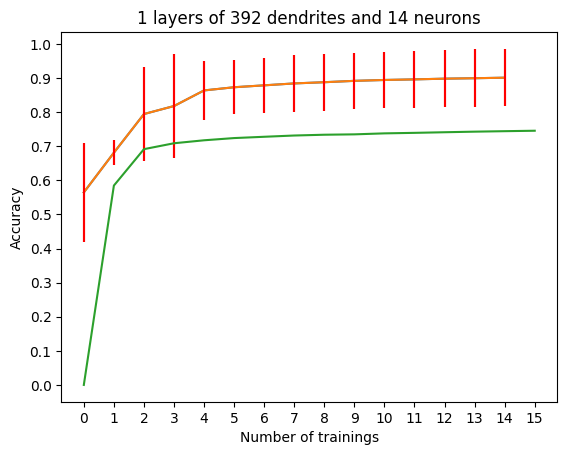

--- NEW MODEL 1 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 5623 / 10000 with accuracy 56.23%
Row: 1 | 392 | 14 | [0, 0.5623]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 7392 / 10000 with accuracy 73.92%
Row: 2 | 392 | 14 | [0, 0.5623, 0.7392]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8023 / 10000 with accuracy 80.23%
Row: 3 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 8145 / 10000 with accuracy 81.45%
Row: 4 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 8221 / 10000 with accuracy 82.21%
Row: 5 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 8297 / 10000 with accuracy 82.97%
Row: 6 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 8341 / 10000 with accuracy 83.41%
Row: 7 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 8359 / 10000 with accuracy 83.59%
Row: 8 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8389 / 10000 with accuracy 83.89%
Row: 9 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389]


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Checking accuracy on test data
Got 8419 / 10000 with accuracy 84.19%
Row: 10 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389, 0.8419]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 8439 / 10000 with accuracy 84.39%
Row: 11 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389, 0.8419, 0.8439]


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Checking accuracy on test data
Got 8470 / 10000 with accuracy 84.70%
Row: 12 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389, 0.8419, 0.8439, 0.847]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 8479 / 10000 with accuracy 84.79%
Row: 13 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389, 0.8419, 0.8439, 0.847, 0.8479]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 8491 / 10000 with accuracy 84.91%
Row: 14 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389, 0.8419, 0.8439, 0.847, 0.8479, 0.8491]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 8511 / 10000 with accuracy 85.11%
Row: 15 | 392 | 14 | [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389, 0.8419, 0.8439, 0.847, 0.8479, 0.8491, 0.8511]


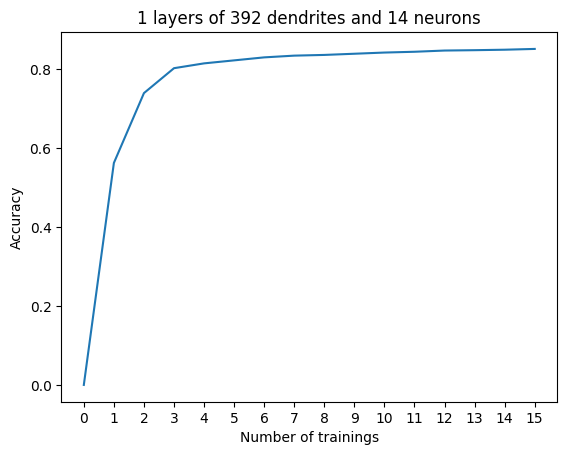

--- NEW MODEL 2 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 5634 / 10000 with accuracy 56.34%
Row: 1 | 392 | 14 | [0, 0.5634]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 6066 / 10000 with accuracy 60.66%
Row: 2 | 392 | 14 | [0, 0.5634, 0.6066]


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Checking accuracy on test data
Got 6172 / 10000 with accuracy 61.72%
Row: 3 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 6252 / 10000 with accuracy 62.52%
Row: 4 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252]


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Checking accuracy on test data
Got 6315 / 10000 with accuracy 63.15%
Row: 5 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 6362 / 10000 with accuracy 63.62%
Row: 6 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362]


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Checking accuracy on test data
Got 6404 / 10000 with accuracy 64.04%
Row: 7 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 6449 / 10000 with accuracy 64.49%
Row: 8 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 6476 / 10000 with accuracy 64.76%
Row: 9 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 6501 / 10000 with accuracy 65.01%
Row: 10 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476, 0.6501]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 6515 / 10000 with accuracy 65.15%
Row: 11 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476, 0.6501, 0.6515]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 6532 / 10000 with accuracy 65.32%
Row: 12 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476, 0.6501, 0.6515, 0.6532]


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Checking accuracy on test data
Got 6548 / 10000 with accuracy 65.48%
Row: 13 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476, 0.6501, 0.6515, 0.6532, 0.6548]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 6566 / 10000 with accuracy 65.66%
Row: 14 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476, 0.6501, 0.6515, 0.6532, 0.6548, 0.6566]


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Checking accuracy on test data
Got 6581 / 10000 with accuracy 65.81%
Row: 15 | 392 | 14 | [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476, 0.6501, 0.6515, 0.6532, 0.6548, 0.6566, 0.6581]


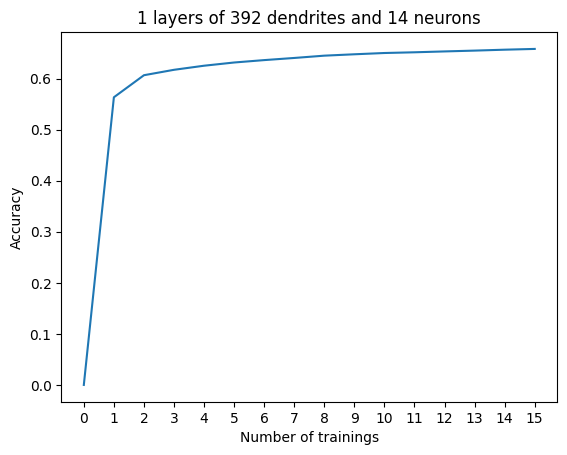

--- NEW MODEL 3 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Checking accuracy on test data
Got 5481 / 10000 with accuracy 54.81%
Row: 1 | 392 | 14 | [0, 0.5481]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 5788 / 10000 with accuracy 57.88%
Row: 2 | 392 | 14 | [0, 0.5481, 0.5788]


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Checking accuracy on test data
Got 6438 / 10000 with accuracy 64.38%
Row: 3 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438]


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Checking accuracy on test data
Got 7178 / 10000 with accuracy 71.78%
Row: 4 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7345 / 10000 with accuracy 73.45%
Row: 5 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345]


100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Checking accuracy on test data
Got 7413 / 10000 with accuracy 74.13%
Row: 6 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 7443 / 10000 with accuracy 74.43%
Row: 7 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 7467 / 10000 with accuracy 74.67%
Row: 8 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 7492 / 10000 with accuracy 74.92%
Row: 9 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 7519 / 10000 with accuracy 75.19%
Row: 10 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492, 0.7519]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 7534 / 10000 with accuracy 75.34%
Row: 11 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492, 0.7519, 0.7534]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 7554 / 10000 with accuracy 75.54%
Row: 12 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492, 0.7519, 0.7534, 0.7554]


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Checking accuracy on test data
Got 7580 / 10000 with accuracy 75.80%
Row: 13 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492, 0.7519, 0.7534, 0.7554, 0.758]


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Checking accuracy on test data
Got 7589 / 10000 with accuracy 75.89%
Row: 14 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492, 0.7519, 0.7534, 0.7554, 0.758, 0.7589]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7599 / 10000 with accuracy 75.99%
Row: 15 | 392 | 14 | [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492, 0.7519, 0.7534, 0.7554, 0.758, 0.7589, 0.7599]


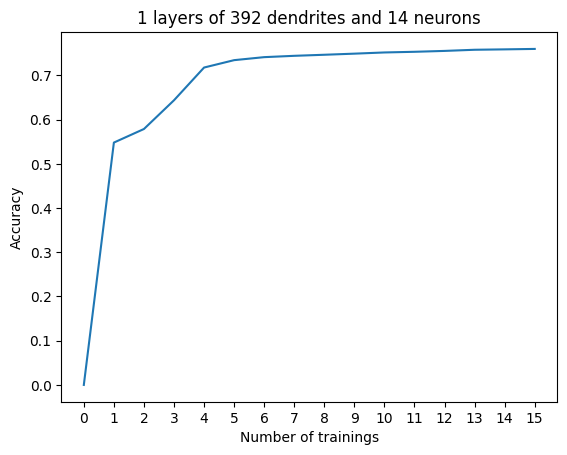

--- NEW MODEL 4 --- 
layer1.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([392, 784])
layer1.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([392])
layer2.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([14, 392])
layer2.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([14])
layer3.weight
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 14])
layer3.bias
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Checking accuracy on test data
Got 6358 / 10000 with accuracy 63.58%
Row: 1 | 392 | 14 | [0, 0.6358]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 7510 / 10000 with accuracy 75.10%
Row: 2 | 392 | 14 | [0, 0.6358, 0.751]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 8683 / 10000 with accuracy 86.83%
Row: 3 | 392 | 14 | [0, 0.6358, 0.751, 0.8683]


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Checking accuracy on test data
Got 8992 / 10000 with accuracy 89.92%
Row: 4 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 9115 / 10000 with accuracy 91.15%
Row: 5 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 9178 / 10000 with accuracy 91.78%
Row: 6 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178]


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Checking accuracy on test data
Got 9226 / 10000 with accuracy 92.26%
Row: 7 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 9271 / 10000 with accuracy 92.71%
Row: 8 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271]


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Checking accuracy on test data
Got 9299 / 10000 with accuracy 92.99%
Row: 9 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299]


100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Checking accuracy on test data
Got 9319 / 10000 with accuracy 93.19%
Row: 10 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299, 0.9319]


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Checking accuracy on test data
Got 9343 / 10000 with accuracy 93.43%
Row: 11 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299, 0.9319, 0.9343]


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Checking accuracy on test data
Got 9371 / 10000 with accuracy 93.71%
Row: 12 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299, 0.9319, 0.9343, 0.9371]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 9398 / 10000 with accuracy 93.98%
Row: 13 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299, 0.9319, 0.9343, 0.9371, 0.9398]


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Checking accuracy on test data
Got 9404 / 10000 with accuracy 94.04%
Row: 14 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299, 0.9319, 0.9343, 0.9371, 0.9398, 0.9404]


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Checking accuracy on test data
Got 9422 / 10000 with accuracy 94.22%
Row: 15 | 392 | 14 | [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299, 0.9319, 0.9343, 0.9371, 0.9398, 0.9404, 0.9422]


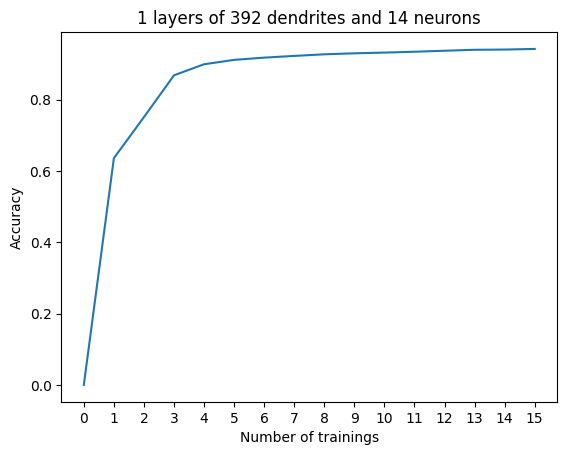

Test 0: [0, 0.5846, 0.6914, 0.7087, 0.7174, 0.7239, 0.7277, 0.7314, 0.7337, 0.7348, 0.7377, 0.7392, 0.741, 0.7427, 0.7441, 0.7454]
Test 1: [0, 0.5623, 0.7392, 0.8023, 0.8145, 0.8221, 0.8297, 0.8341, 0.8359, 0.8389, 0.8419, 0.8439, 0.847, 0.8479, 0.8491, 0.8511]
Test 2: [0, 0.5634, 0.6066, 0.6172, 0.6252, 0.6315, 0.6362, 0.6404, 0.6449, 0.6476, 0.6501, 0.6515, 0.6532, 0.6548, 0.6566, 0.6581]
Test 3: [0, 0.5481, 0.5788, 0.6438, 0.7178, 0.7345, 0.7413, 0.7443, 0.7467, 0.7492, 0.7519, 0.7534, 0.7554, 0.758, 0.7589, 0.7599]
Test 4: [0, 0.6358, 0.751, 0.8683, 0.8992, 0.9115, 0.9178, 0.9226, 0.9271, 0.9299, 0.9319, 0.9343, 0.9371, 0.9398, 0.9404, 0.9422]


In [69]:
# Factors of 392
# 1, 2, 4, 7, 8, 14, 28, 49, 56, 98, 196, 392.

num_dendritic_inputs = 392
num_neurons = 14
num_dendrite_neuron_layers = 1

num_trials = 5
num_trainings = 15 
data = {}

for trial in range(num_trials):
  print(f"--- NEW MODEL {trial} --- ")
  data[trial] = run_trials(num_dendritic_inputs, num_neurons, num_dendrite_neuron_layers, num_trainings)

# Print data after all runs
for i in range(num_trials):
  print(f"Test {i}: {data[i]}")

         0       1       2       3       4
0   0.0000  0.0000  0.0000  0.0000  0.0000
1   0.5846  0.5623  0.5634  0.5481  0.6358
2   0.6914  0.7392  0.6066  0.5788  0.7510
3   0.7087  0.8023  0.6172  0.6438  0.8683
4   0.7174  0.8145  0.6252  0.7178  0.8992
5   0.7239  0.8221  0.6315  0.7345  0.9115
6   0.7277  0.8297  0.6362  0.7413  0.9178
7   0.7314  0.8341  0.6404  0.7443  0.9226
8   0.7337  0.8359  0.6449  0.7467  0.9271
9   0.7348  0.8389  0.6476  0.7492  0.9299
10  0.7377  0.8419  0.6501  0.7519  0.9319
11  0.7392  0.8439  0.6515  0.7534  0.9343
12  0.7410  0.8470  0.6532  0.7554  0.9371
13  0.7427  0.8479  0.6548  0.7580  0.9398
14  0.7441  0.8491  0.6566  0.7589  0.9404
15  0.7454  0.8511  0.6581  0.7599  0.9422
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


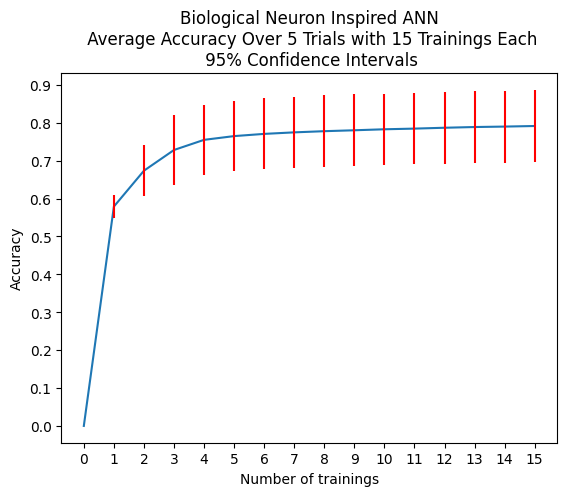

In [76]:
# Convert list of data over tests into a data frame
df = pd.DataFrame(data)

# Set up x axis ticks
x_values = list(range(len(df)))
trial_idx_list = list(range(num_trials))

# List of confidence intervals at each training
ci_values = []

mean_values = df[trial_idx_list].mean(axis=1).tolist()

for _, row in df[trial_idx_list].iterrows():
  mean = row.mean()
  sem = row.sem()
  ci = sem * 1.96  # 95% confidence interval
  ci_values.append(ci)

# Plot styling
plt.title(f"Biological Neuron Inspired ANN\n Average Accuracy Over {num_trials} Trials with {num_trainings} Trainings Each\n 95% Confidence Intervals")
plt.xlabel("Number of trainings")
plt.ylabel("Accuracy")

plt.xticks(np.arange(0, 16, 1))
plt.yticks(np.arange(0, 1.1, 0.1))

sns.lineplot(x = x_values, y = mean_values)
plt.errorbar(x = x_values, y = mean_values, yerr=ci_values, linestyle='None', color='red')
plt.show()
